In [2]:
import pandas as pd
import psycopg2
import time
import numpy as np
import re
from datetime import timedelta
import pickle
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy import stats


In [33]:
DB_NAME = "cognitive_battery"

conn = psycopg2.connect(
    host="127.0.0.1",
    port="5432",
    database=DB_NAME,
    user="postgres",
    password="postgres"
)



In [5]:
# Execute the SQL query
cursor = conn.cursor()
sql_query = "SELECT * FROM public.survey_data"
cursor.execute(sql_query)

# Fetch all the results
columns = [desc[0] for desc in cursor.description]
data = cursor.fetchall()
df_survey = pd.DataFrame(data, columns=columns)

cursor.close()
df_survey

,userid,enumeration_data,task_switching_data,working_memory_data,demographic_inventory_data,trust_scale_data,gaming_experience_data,state_trait_data,new_statetrait_data
0,HPLX,"{'BlockNo': [1, 2, 3], 'Q2': [10, 13, 15], 'Q3...","{'BlockNo': [1, 2, 3], 'Q2': [6, 14, 10], 'Q3'...","{'BlockNo': [1, 2, 3], 'Q2': [3, 13, 10], 'Q3'...","{'BlockNo': [1], 'Q2': [19], 'Q3': ['Male'], '...","{'BlockNo': [1], 'Q2': [3], 'Q3': [5], 'Q4': [...","{'BlockNo': [1], 'Q2': ['5-10 years'], 'Q3': [...",No Data,"{'BlockNo': [1], 'Q2': [4], 'Q3': [2], 'Q4': [..."
1,TYDF,"{'BlockNo': [1, 2, 3], 'Q2': [15, 6, 19], 'Q3'...","{'BlockNo': [1, 2], 'Q2': [3, 17], 'Q3': [19, ...","{'BlockNo': [1, 2, 3], 'Q2': [1, 2, 10], 'Q3':...","{'BlockNo': [1], 'Q2': [20], 'Q3': ['Male'], '...","{'BlockNo': [1], 'Q2': [5], 'Q3': [5], 'Q4': [...","{'BlockNo': [1], 'Q2': ['10 or more years'], '...","{'BlockNo': [1], 'Q2': [3], 'Q3': [3], 'Q4': [...",No Data
2,JFDE,"{'BlockNo': [1, 2, 3], 'Q2': [11, 12, 7], 'Q3'...","{'BlockNo': [1, 2, 3], 'Q2': [13, 12, 9], 'Q3'...","{'BlockNo': [1, 2, 3], 'Q2': [3, 8, 14], 'Q3':...","{'BlockNo': [1], 'Q2': [22], 'Q3': ['Male'], '...","{'BlockNo': [1], 'Q2': [5], 'Q3': [6], 'Q4': [...","{'BlockNo': [1], 'Q2': ['10 or more years'], '...",No Data,"{'BlockNo': [1], 'Q2': [4], 'Q3': [2], 'Q4': [..."
3,UJNH,"{'BlockNo': [1, 2, 3], 'Q2': [4, 10, 11], 'Q3'...","{'BlockNo': [1, 2, 3], 'Q2': [8, 4, 8], 'Q3': ...","{'BlockNo': [1, 2, 3], 'Q2': [1, 1, 11], 'Q3':...","{'BlockNo': [1], 'Q2': [20], 'Q3': ['Male'], '...","{'BlockNo': [1], 'Q2': [4], 'Q3': [6], 'Q4': [...","{'BlockNo': [1], 'Q2': ['10 or more years'], '...",No Data,"{'BlockNo': [1], 'Q2': [4], 'Q3': [1], 'Q4': [..."
4,MNBW,"{'BlockNo': [1, 2, 3], 'Q2': [20, 20, 10], 'Q3...","{'BlockNo': [1, 2, 3], 'Q2': [16, 8, 17], 'Q3'...","{'BlockNo': [1, 2, 3], 'Q2': [7, 16, 2], 'Q3':...","{'BlockNo': [1], 'Q2': [21], 'Q3': ['Male'], '...","{'BlockNo': [1], 'Q2': [5], 'Q3': [5], 'Q4': [...","{'BlockNo': [1], 'Q2': ['10 or more years'], '...","{'BlockNo': [1], 'Q2': [2], 'Q3': [3], 'Q4': [...",No Data
...,...,...,...,...,...,...,...,...,...
95,RIQW,"{'BlockNo': [1, 2, 3], 'Q2': [17, 19, 14], 'Q3...","{'BlockNo': [1, 2, 3], 'Q2': [15, 16, 9], 'Q3'...","{'BlockNo': [1, 2, 3], 'Q2': [11, 12, 5], 'Q3'...","{'BlockNo': [1], 'Q2': [18], 'Q3': ['Male'], '...","{'BlockNo': [1], 'Q2': [4], 'Q3': [6], 'Q4': [...","{'BlockNo': [1], 'Q2': ['10 or more years'], '...",No Data,"{'BlockNo': [1], 'Q2': [3], 'Q3': [3], 'Q4': [..."
96,LKPW,"{'BlockNo': [1, 2, 3], 'Q2': [8, 8, 15], 'Q3':...","{'BlockNo': [1, 2, 3], 'Q2': [10, 4, 5], 'Q3':...","{'BlockNo': [1, 2, 3], 'Q2': [12, 3, 13], 'Q3'...","{'BlockNo': [1], 'Q2': [20], 'Q3': ['Male'], '...","{'BlockNo': [1], 'Q2': [5], 'Q3': [4], 'Q4': [...","{'BlockNo': [1], 'Q2': ['10 or more years'], '...","{'BlockNo': [1], 'Q2': [3], 'Q3': [3], 'Q4': [...",No Data
97,VFTY,"{'BlockNo': [1, 2, 3], 'Q2': [16, 8, 20], 'Q3'...","{'BlockNo': [1, 2, 3], 'Q2': [12, 19, 10], 'Q3...","{'BlockNo': [1, 2, 3], 'Q2': [20, 13, 1], 'Q3'...","{'BlockNo': [1], 'Q2': [25], 'Q3': ['Male'], '...","{'BlockNo': [1], 'Q2': [7], 'Q3': [7], 'Q4': [...","{'BlockNo': [1], 'Q2': ['10 or more years'], '...","{'BlockNo': [1], 'Q2': [1], 'Q3': [2], 'Q4': [...",No Data
98,POIU,"{'BlockNo': [1, 2, 3], 'Q2': [19, 15, 20], 'Q3...","{'BlockNo': [1, 2, 3], 'Q2': [11, 6, 11], 'Q3'...","{'BlockNo': [1, 2, 3], 'Q2': [2, 15, 18], 'Q3'...","{'BlockNo': [1], 'Q2': [24], 'Q3': ['Male'], '...","{'BlockNo': [1], 'Q2': [5], 'Q3': [3], 'Q4': [...","{'BlockNo': [1], 'Q2': ['10 or more years'], '...",No Data,"{'BlockNo': [1], 'Q2': [2], 'Q3': [3], 'Q4': [..."


### Get enumeration

In [34]:
cursor = conn.cursor()
sql_query = "SELECT * FROM public.enumeration"
cursor.execute(sql_query)

# Fetch all the results
columns = [desc[0] for desc in cursor.description]
data = cursor.fetchall()
df_enumeration_game = pd.DataFrame(data, columns=columns)

cursor.close()
df_enumeration_game

,userid,data
0,BVCX,"{'Blockno': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,CVBN,"{'Blockno': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,DKLQ,"{'Blockno': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,EDFR,"{'Blockno': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,FDSA,"{'Blockno': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...
95,SPKZR,"{'Blockno': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
96,SRKLP,"{'Blockno': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
97,VFTY,"{'Blockno': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
98,XUYP,"{'Blockno': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [53]:
df_temp = pd.DataFrame(df_enumeration_game['data'].to_list())[['Blockno','Difficulty']]
df_temp = pd.concat([df_enumeration_game[['userid']],df_temp],axis=1) #add userid
df_temp = df_temp.rename({'Blockno':'BlockNo'},axis=1)
df_temp = df_temp.explode(['BlockNo','Difficulty']).drop_duplicates()
df_temp

,userid,BlockNo,Difficulty
0,BVCX,1,Easy
0,BVCX,2,Medium
0,BVCX,3,Hard
1,CVBN,1,Hard
1,CVBN,2,Medium
...,...,...,...
98,XUYP,2,Medium
98,XUYP,3,Hard
99,YTRE,1,Hard
99,YTRE,2,Medium


In [54]:
df_enumeration = pd.DataFrame(df_survey['enumeration_data'].to_list())
df_enumeration = pd.concat([df_survey[['userid']],df_enumeration],axis=1) #add userid
df_enumeration = df_enumeration.explode(['BlockNo','Q2','Q3','Q4','Q5','Q6'])

df_enumeration = df_enumeration.rename({"Q2": "How challenging was it? How hard did you have to work?", 
                                        "Q3": "How successful were you in accomplishing the task goals?",
                                        "Q4": "How stressful, discouraging, and irritating was the task?",
                                        "Q5": "How mentally demanding was the task?", 
                                        "Q6": "How hurried or rushed was the pace of the task?"},axis=1) #filter and remane columns
df_enumeration['game_type'] = 'enumuration'
#df_enumeration = df_enumeration.drop('BlockNo',axis=1)
df_enumeration

,userid,BlockNo,How challenging was it? How hard did you have to work?,How successful were you in accomplishing the task goals?,"How stressful, discouraging, and irritating was the task?",How mentally demanding was the task?,How hurried or rushed was the pace of the task?,game_type
0,HPLX,1,10,14,2,3,10,enumuration
0,HPLX,2,13,10,7,7,13,enumuration
0,HPLX,3,15,13,11,12,15,enumuration
1,TYDF,1,15,15,19,12,20,enumuration
1,TYDF,2,6,17,9,4,12,enumuration
...,...,...,...,...,...,...,...,...
98,POIU,2,15,12,15,15,16,enumuration
98,POIU,3,20,3,20,20,20,enumuration
99,FGHZ,1,9,10,10,10,15,enumuration
99,FGHZ,2,16,8,14,15,17,enumuration


In [57]:
df_enumeration = pd.merge(df_temp,df_enumeration,on=['userid','BlockNo'],how='outer')
df_enumeration

,userid,BlockNo,Difficulty,How challenging was it? How hard did you have to work?,How successful were you in accomplishing the task goals?,"How stressful, discouraging, and irritating was the task?",How mentally demanding was the task?,How hurried or rushed was the pace of the task?,game_type
0,BVCX,1,Easy,7,7,12,10,20,enumuration
1,BVCX,2,Medium,9,8,11,9,20,enumuration
2,BVCX,3,Hard,17,2,11,4,20,enumuration
3,CVBN,1,Hard,15,11,6,8,17,enumuration
4,CVBN,2,Medium,18,10,13,10,19,enumuration
...,...,...,...,...,...,...,...,...,...
299,YTRE,3,Easy,11,13,10,11,12,enumuration
300,CVBN,4,NaN,6,17,4,5,6,enumuration
301,SRKLP,4,NaN,20,15,20,20,20,enumuration
302,SRKLP,5,NaN,15,9,14,13,10,enumuration


In [58]:
df_enumeration[df_enumeration.isna().any(axis=1)]

,userid,BlockNo,Difficulty,How challenging was it? How hard did you have to work?,How successful were you in accomplishing the task goals?,"How stressful, discouraging, and irritating was the task?",How mentally demanding was the task?,How hurried or rushed was the pace of the task?,game_type
50,QWRT,3,Easy,NaN,NaN,NaN,NaN,NaN,NaN
146,SNMVN,3,Easy,NaN,NaN,NaN,NaN,NaN,NaN
300,CVBN,4,NaN,6,17,4,5,6,enumuration
301,SRKLP,4,NaN,20,15,20,20,20,enumuration
302,SRKLP,5,NaN,15,9,14,13,10,enumuration
303,SRKLP,6,NaN,8,12,5,7,4,enumuration


In [59]:
df_enumeration = df_enumeration.dropna()
df_enumeration

,userid,BlockNo,Difficulty,How challenging was it? How hard did you have to work?,How successful were you in accomplishing the task goals?,"How stressful, discouraging, and irritating was the task?",How mentally demanding was the task?,How hurried or rushed was the pace of the task?,game_type
0,BVCX,1,Easy,7,7,12,10,20,enumuration
1,BVCX,2,Medium,9,8,11,9,20,enumuration
2,BVCX,3,Hard,17,2,11,4,20,enumuration
3,CVBN,1,Hard,15,11,6,8,17,enumuration
4,CVBN,2,Medium,18,10,13,10,19,enumuration
...,...,...,...,...,...,...,...,...,...
295,XUYP,2,Medium,18,7,7,19,20,enumuration
296,XUYP,3,Hard,19,7,17,18,20,enumuration
297,YTRE,1,Hard,14,10,12,10,14,enumuration
298,YTRE,2,Medium,14,9,13,13,14,enumuration


### task_switching

In [60]:
cursor = conn.cursor()
sql_query = "SELECT * FROM public.task_switching"
cursor.execute(sql_query)

# Fetch all the results
columns = [desc[0] for desc in cursor.description]
data = cursor.fetchall()
df_task_switching_game = pd.DataFrame(data, columns=columns)

cursor.close()
df_task_switching_game

,userid,data
0,BVCX,"{'Blockno': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,CVBN,"{'Blockno': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,DKLQ,"{'Blockno': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,EDFR,"{'Blockno': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,FDSA,"{'Blockno': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...
95,SPKZR,"{'Blockno': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
96,SRKLP,"{'Blockno': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
97,VFTY,"{'Blockno': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
98,XUYP,"{'Blockno': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [61]:
df_temp = pd.DataFrame(df_task_switching_game['data'].to_list())[['Blockno','Difficulty']]
df_temp = pd.concat([df_task_switching_game[['userid']],df_temp],axis=1) #add userid
df_temp = df_temp.rename({'Blockno':'BlockNo'},axis=1)
df_temp = df_temp.explode(['BlockNo','Difficulty']).drop_duplicates()
df_temp

,userid,BlockNo,Difficulty
0,BVCX,1,Hard
0,BVCX,2,Easy
0,BVCX,3,Medium
1,CVBN,1,Hard
1,CVBN,2,Easy
...,...,...,...
98,XUYP,2,Easy
98,XUYP,3,Medium
99,YTRE,1,Medium
99,YTRE,2,Easy


In [62]:
df_task_switching = pd.DataFrame(df_survey['task_switching_data'].to_list())
df_task_switching = pd.concat([df_survey[['userid']],df_task_switching],axis=1) #add userid
df_task_switching = df_task_switching.explode(['BlockNo','Q2','Q3','Q4','Q5','Q6'])

df_task_switching = df_task_switching.rename({"Q2": "How challenging was it? How hard did you have to work?", 
                                        "Q3": "How successful were you in accomplishing the task goals?",
                                        "Q4": "How stressful, discouraging, and irritating was the task?",
                                        "Q5": "How mentally demanding was the task?", 
                                        "Q6": "How hurried or rushed was the pace of the task?"},axis=1) #filter and remane columns
df_task_switching['game_type'] = 'task_switching'
df_task_switching

,userid,BlockNo,How challenging was it? How hard did you have to work?,How successful were you in accomplishing the task goals?,"How stressful, discouraging, and irritating was the task?",How mentally demanding was the task?,How hurried or rushed was the pace of the task?,game_type
0,HPLX,1,6,16,4,4,1,task_switching
0,HPLX,2,14,6,14,14,14,task_switching
0,HPLX,3,10,14,8,7,9,task_switching
1,TYDF,1,3,19,1,4,18,task_switching
1,TYDF,2,17,16,9,14,20,task_switching
...,...,...,...,...,...,...,...,...
98,POIU,2,6,16,5,8,15,task_switching
98,POIU,3,11,17,10,8,17,task_switching
99,FGHZ,1,7,16,6,7,8,task_switching
99,FGHZ,2,7,14,8,8,8,task_switching


In [63]:
df_task_switching = pd.merge(df_temp,df_task_switching,on=['userid','BlockNo'],how='outer')
df_task_switching

,userid,BlockNo,Difficulty,How challenging was it? How hard did you have to work?,How successful were you in accomplishing the task goals?,"How stressful, discouraging, and irritating was the task?",How mentally demanding was the task?,How hurried or rushed was the pace of the task?,game_type
0,BVCX,1,Hard,11,15,5,6,15,task_switching
1,BVCX,2,Easy,11,15,13,10,10,task_switching
2,BVCX,3,Medium,8,18,9,7,14,task_switching
3,CVBN,1,Hard,14,13,14,15,12,task_switching
4,CVBN,2,Easy,10,14,10,12,11,task_switching
...,...,...,...,...,...,...,...,...,...
296,XUYP,3,Medium,14,9,16,19,15,task_switching
297,YTRE,1,Medium,12,12,11,13,11,task_switching
298,YTRE,2,Easy,13,13,9,11,10,task_switching
299,YTRE,3,Hard,15,14,11,12,15,task_switching


In [64]:
df_task_switching[df_task_switching.isna().any(axis=1)]

,userid,BlockNo,Difficulty,How challenging was it? How hard did you have to work?,How successful were you in accomplishing the task goals?,"How stressful, discouraging, and irritating was the task?",How mentally demanding was the task?,How hurried or rushed was the pace of the task?,game_type
71,TYDF,3,Hard,NaN,NaN,NaN,NaN,NaN,NaN
218,STWXJ,3,Hard,NaN,NaN,NaN,NaN,NaN,NaN
300,SVTZM,4,NaN,8,3,8,8,13,task_switching


In [65]:
df_task_switching[df_task_switching['userid'] == 'SVTZM']

,userid,BlockNo,Difficulty,How challenging was it? How hard did you have to work?,How successful were you in accomplishing the task goals?,"How stressful, discouraging, and irritating was the task?",How mentally demanding was the task?,How hurried or rushed was the pace of the task?,game_type
60,SVTZM,1,Easy,15,4,4,9,5,task_switching
61,SVTZM,2,Hard,17,3,7,6,5,task_switching
62,SVTZM,3,Medium,17,2,9,9,17,task_switching
300,SVTZM,4,NaN,8,3,8,8,13,task_switching


In [66]:
df_task_switching = df_task_switching.dropna()
df_task_switching

,userid,BlockNo,Difficulty,How challenging was it? How hard did you have to work?,How successful were you in accomplishing the task goals?,"How stressful, discouraging, and irritating was the task?",How mentally demanding was the task?,How hurried or rushed was the pace of the task?,game_type
0,BVCX,1,Hard,11,15,5,6,15,task_switching
1,BVCX,2,Easy,11,15,13,10,10,task_switching
2,BVCX,3,Medium,8,18,9,7,14,task_switching
3,CVBN,1,Hard,14,13,14,15,12,task_switching
4,CVBN,2,Easy,10,14,10,12,11,task_switching
...,...,...,...,...,...,...,...,...,...
295,XUYP,2,Easy,9,18,1,17,13,task_switching
296,XUYP,3,Medium,14,9,16,19,15,task_switching
297,YTRE,1,Medium,12,12,11,13,11,task_switching
298,YTRE,2,Easy,13,13,9,11,10,task_switching


### working_memory

In [72]:
cursor = conn.cursor()
sql_query = "SELECT * FROM public.working_memory"
cursor.execute(sql_query)

# Fetch all the results
columns = [desc[0] for desc in cursor.description]
data = cursor.fetchall()
df_working_memory_game = pd.DataFrame(data, columns=columns)

cursor.close()
df_working_memory_game

,userid,data
0,BVCX,"{'BlockNo': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,CVBN,"{'BlockNo': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,DKLQ,"{'BlockNo': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,EDFR,"{'BlockNo': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,FDSA,"{'BlockNo': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...
92,SPKZR,"{'BlockNo': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
93,SRKLP,"{'BlockNo': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
94,VFTY,"{'BlockNo': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
95,XUYP,"{'BlockNo': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [74]:
df_temp = pd.DataFrame(df_working_memory_game['data'].to_list())[['BlockNo','Difficulty']]
df_temp = pd.concat([df_working_memory_game[['userid']],df_temp],axis=1) #add userid
#df_temp = df_temp.rename({'Blockno':'BlockNo'},axis=1)
df_temp = df_temp.explode(['BlockNo','Difficulty']).drop_duplicates()
df_temp

,userid,BlockNo,Difficulty
0,BVCX,1,Easy
0,BVCX,2,Hard
0,BVCX,3,Medium
1,CVBN,1,Easy
1,CVBN,2,Hard
...,...,...,...
95,XUYP,2,Hard
95,XUYP,3,Medium
96,YTRE,1,Easy
96,YTRE,2,Hard


In [75]:
df_working_memory = pd.DataFrame(df_survey['working_memory_data'].to_list())
df_working_memory = pd.concat([df_survey[['userid']],df_working_memory],axis=1) #add userid
df_working_memory = df_working_memory.explode(['BlockNo','Q2','Q3','Q4','Q5','Q6'])

df_working_memory = df_working_memory.rename({"Q2": "How challenging was it? How hard did you have to work?", 
                                        "Q3": "How successful were you in accomplishing the task goals?",
                                        "Q4": "How stressful, discouraging, and irritating was the task?",
                                        "Q5": "How mentally demanding was the task?", 
                                        "Q6": "How hurried or rushed was the pace of the task?"},axis=1) #filter and remane columns
df_working_memory['game_type'] = 'working_memory'
#df_working_memory = df_working_memory.drop('BlockNo',axis=1)
df_working_memory

,userid,BlockNo,How challenging was it? How hard did you have to work?,How successful were you in accomplishing the task goals?,"How stressful, discouraging, and irritating was the task?",How mentally demanding was the task?,How hurried or rushed was the pace of the task?,game_type
0,HPLX,1,3,17,3,3,3,working_memory
0,HPLX,2,13,11,8,11,11,working_memory
0,HPLX,3,10,16,6,9,8,working_memory
1,TYDF,1,1,20,1,1,1,working_memory
1,TYDF,2,2,18,2,2,1,working_memory
...,...,...,...,...,...,...,...,...
98,POIU,2,15,16,5,12,16,working_memory
98,POIU,3,18,11,15,15,15,working_memory
99,FGHZ,1,2,18,4,4,4,working_memory
99,FGHZ,2,14,12,9,11,8,working_memory


In [76]:
df_working_memory = pd.merge(df_temp,df_working_memory,on=['userid','BlockNo'],how='outer')
df_working_memory

,userid,BlockNo,Difficulty,How challenging was it? How hard did you have to work?,How successful were you in accomplishing the task goals?,"How stressful, discouraging, and irritating was the task?",How mentally demanding was the task?,How hurried or rushed was the pace of the task?,game_type
0,BVCX,1,Easy,3,20,2,3,11,working_memory
1,BVCX,2,Hard,16,10,11,7,9,working_memory
2,BVCX,3,Medium,10,13,7,10,9,working_memory
3,CVBN,1,Easy,2,20,2,1,3,working_memory
4,CVBN,2,Hard,19,6,14,18,5,working_memory
...,...,...,...,...,...,...,...,...,...
300,SHYXZ,3,NaN,16,2,15,16,6,working_memory
301,XRTY,4,NaN,4,18,1,8,1,working_memory
302,XRTY,5,NaN,17,10,10,19,11,working_memory
303,XRTY,6,NaN,4,17,2,4,1,working_memory


In [78]:
df_working_memory[df_working_memory.isna().any(axis=1)]

,userid,BlockNo,Difficulty,How challenging was it? How hard did you have to work?,How successful were you in accomplishing the task goals?,"How stressful, discouraging, and irritating was the task?",How mentally demanding was the task?,How hurried or rushed was the pace of the task?,game_type
291,TYDF,1,NaN,1,20,1,1,1,working_memory
292,TYDF,2,NaN,2,18,2,2,1,working_memory
293,TYDF,3,NaN,10,14,13,14,3,working_memory
294,RQWE,1,NaN,18,4,14,18,3,working_memory
295,RQWE,2,NaN,14,13,10,13,2,working_memory
296,RQWE,3,NaN,3,19,3,5,2,working_memory
297,XUYP,4,NaN,13,5,10,20,15,working_memory
298,SHYXZ,1,NaN,3,18,2,3,3,working_memory
299,SHYXZ,2,NaN,10,8,8,9,6,working_memory
300,SHYXZ,3,NaN,16,2,15,16,6,working_memory


In [79]:
df_working_memory = df_working_memory.dropna()
df_working_memory

,userid,BlockNo,Difficulty,How challenging was it? How hard did you have to work?,How successful were you in accomplishing the task goals?,"How stressful, discouraging, and irritating was the task?",How mentally demanding was the task?,How hurried or rushed was the pace of the task?,game_type
0,BVCX,1,Easy,3,20,2,3,11,working_memory
1,BVCX,2,Hard,16,10,11,7,9,working_memory
2,BVCX,3,Medium,10,13,7,10,9,working_memory
3,CVBN,1,Easy,2,20,2,1,3,working_memory
4,CVBN,2,Hard,19,6,14,18,5,working_memory
...,...,...,...,...,...,...,...,...,...
286,XUYP,2,Hard,11,8,12,17,15,working_memory
287,XUYP,3,Medium,15,5,13,19,16,working_memory
288,YTRE,1,Easy,8,19,6,7,6,working_memory
289,YTRE,2,Hard,16,4,13,15,10,working_memory


### Merge all

In [90]:
pd_merged = pd.concat([df_enumeration,df_task_switching,df_working_memory],axis=0)
pd_merged.to_csv("probe_with_dificulty_data.csv",index=False)
pd_merged


,userid,BlockNo,Difficulty,How challenging was it? How hard did you have to work?,How successful were you in accomplishing the task goals?,"How stressful, discouraging, and irritating was the task?",How mentally demanding was the task?,How hurried or rushed was the pace of the task?,game_type
0,BVCX,1,Easy,7,7,12,10,20,enumuration
1,BVCX,2,Medium,9,8,11,9,20,enumuration
2,BVCX,3,Hard,17,2,11,4,20,enumuration
3,CVBN,1,Hard,15,11,6,8,17,enumuration
4,CVBN,2,Medium,18,10,13,10,19,enumuration
...,...,...,...,...,...,...,...,...,...
286,XUYP,2,Hard,11,8,12,17,15,working_memory
287,XUYP,3,Medium,15,5,13,19,16,working_memory
288,YTRE,1,Easy,8,19,6,7,6,working_memory
289,YTRE,2,Hard,16,4,13,15,10,working_memory


In [92]:
pd_average = pd_merged.drop(['userid','BlockNo'],axis=1).groupby(['Difficulty','game_type']).mean().reset_index()
pd_average.to_csv("probe_with_dificulty_averaged_data.csv",index=False)
pd_average

,Difficulty,game_type,How challenging was it? How hard did you have to work?,How successful were you in accomplishing the task goals?,"How stressful, discouraging, and irritating was the task?",How mentally demanding was the task?,How hurried or rushed was the pace of the task?
0,Easy,enumuration,10.663265,12.0,6.653061,9.714286,12.510204
1,Easy,task_switching,9.03,13.51,6.7,9.5,9.4
2,Easy,working_memory,3.958763,17.350515,2.42268,4.43299,3.474227
3,Hard,enumuration,16.03,8.28,9.45,13.26,17.53
4,Hard,task_switching,13.346939,9.928571,9.336735,12.153061,14.459184
5,Hard,working_memory,14.618557,7.876289,8.865979,13.835052,8.226804
6,Medium,enumuration,13.66,10.27,8.16,11.34,15.19
7,Medium,task_switching,9.46,13.13,6.79,9.47,10.19
8,Medium,working_memory,9.206186,13.072165,5.762887,8.927835,6.381443


# ploting

In [81]:
pd_merged.columns

Index(['userid', 'BlockNo', 'Difficulty',
       'How challenging was it? How hard did you have to work?',
       'How successful were you in accomplishing the task goals?',
       'How stressful, discouraging, and irritating was the task?',
       'How mentally demanding was the task?',
       'How hurried or rushed was the pace of the task?', 'game_type'],
      dtype='object')

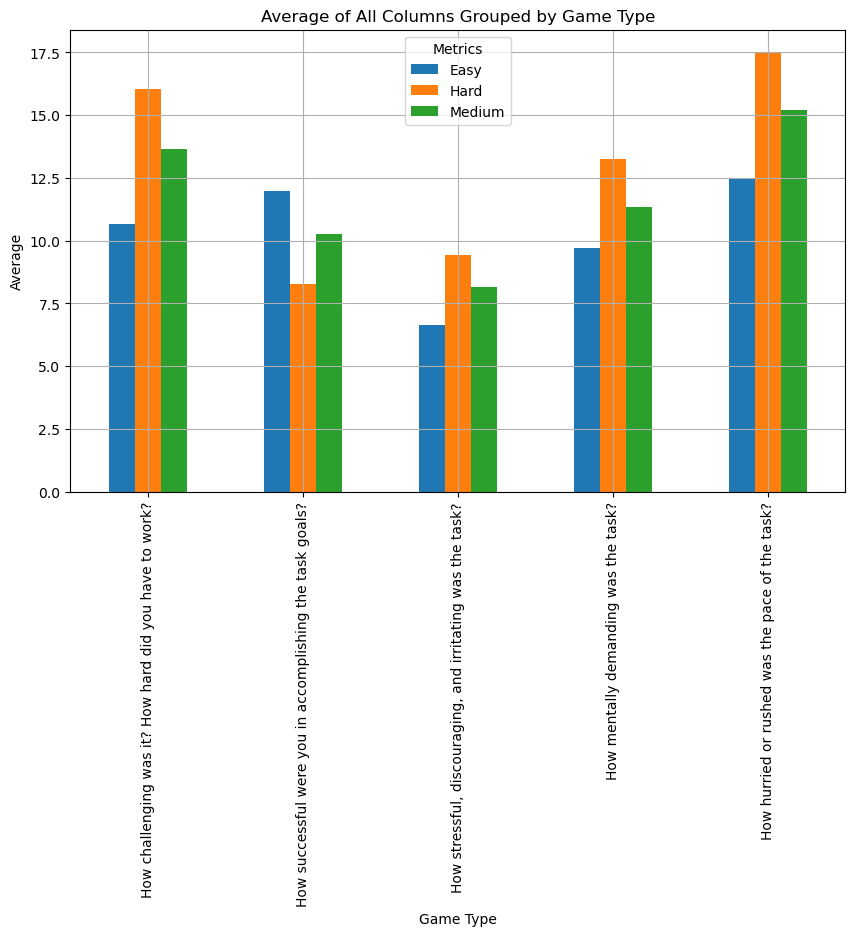

In [83]:
averages = pd_merged[pd_merged['game_type'] == 'enumuration'].drop(['userid','BlockNo','game_type'],axis=1).groupby('Difficulty').mean().T

# Plot the averages
averages.plot(kind='bar', figsize=(10, 6))
plt.title('Average of All Columns Grouped by Game Type')
plt.xlabel('Game Type')
plt.ylabel('Average')
plt.legend(title='Metrics')
plt.grid(True)
plt.show()

In [82]:
pd_merged[pd_merged['game_type'] == 'enumuration']

,userid,BlockNo,Difficulty,How challenging was it? How hard did you have to work?,How successful were you in accomplishing the task goals?,"How stressful, discouraging, and irritating was the task?",How mentally demanding was the task?,How hurried or rushed was the pace of the task?,game_type
0,BVCX,1,Easy,7,7,12,10,20,enumuration
1,BVCX,2,Medium,9,8,11,9,20,enumuration
2,BVCX,3,Hard,17,2,11,4,20,enumuration
3,CVBN,1,Hard,15,11,6,8,17,enumuration
4,CVBN,2,Medium,18,10,13,10,19,enumuration
...,...,...,...,...,...,...,...,...,...
295,XUYP,2,Medium,18,7,7,19,20,enumuration
296,XUYP,3,Hard,19,7,17,18,20,enumuration
297,YTRE,1,Hard,14,10,12,10,14,enumuration
298,YTRE,2,Medium,14,9,13,13,14,enumuration
